In [1]:
import matplotlib.pyplot as plt
import numpy as np
import flet as ft
import os
from pylsl import StreamInlet, resolve_stream
from scipy.signal import welch, spectrogram
from sklearn.metrics import precision_score, recall_score, f1_score, confusion_matrix, accuracy_score
import pandas as pd
from joblib import dump
import pyxdf
from sklearn.model_selection import train_test_split
import seaborn as sns


Authorization classes are not loaded, using fake implementations.


In [2]:
# Combine all data stored in the same folder to use for training the model.
def concat_data(frequency):
    data_folder = f'../../../../data_ssvep/Toey/flicker1/{frequency}/'
    all_data = []
    for file_name in os.listdir(data_folder):
        file_path = os.path.join(data_folder, file_name)
        streams, _ = pyxdf.load_xdf(file_path)
        raw_data = streams[0]["time_series"].T
        all_data.append(raw_data)
    all_data_array = np.concatenate(all_data, axis=1)
    return all_data_array


In [3]:
# The stored data will be kept for an average of 80 seconds, so the data will be cut into parts. set_size is the sample that you want per 1 set. overlap is how much data in each set will overlap.
def create_overlapping_sets(data, set_size=500, overlap_fraction=0.5):
    step = int(set_size * (1 - overlap_fraction))
    sets = []
    for i in range(0, len(data) - set_size + 1, step):
        sets.append(data[i:i + set_size])
    return sets

In [4]:
name_data = 'psychopy'
raw_data1 = concat_data('6Hz')
print(raw_data1.shape)
raw_data2 = concat_data('20Hz')
print(raw_data2.shape)
raw_data3 = concat_data('0Hz')
print(raw_data3.shape)

(8, 164640)
(8, 166330)
(8, 167630)


In [5]:
# Store data in only 4 channels: Oz Pz O1 O2
data1 = raw_data1[0:4,:]
data2 = raw_data2[0:4,:]
data3 = raw_data3[0:4,:]
print(data1.shape)
print(data2.shape)
print(data3.shape)

(4, 164640)
(4, 166330)
(4, 167630)


In [6]:
# Adjust the reference using Pz as the channel ref.
data1_oz = data1[0] - data1[1]
data1_o1 = data1[2] - data1[1]
data1_o2 = data1[3] - data1[1]

data2_oz = data2[0] - data2[1]
data2_o1 = data2[2] - data2[1]
data2_o2 = data2[3] - data2[1]

data3_oz = data3[0] - data3[1]
data3_o1 = data3[2] - data3[1]
data3_o2 = data3[3] - data3[1]

print(data1_oz.shape, data1_o1.shape, data1_o2.shape)
print(data2_oz.shape, data2_o1.shape, data2_o2.shape)
print(data3_oz.shape, data3_o1.shape, data3_o2.shape)

(164640,) (164640,) (164640,)
(166330,) (166330,) (166330,)
(167630,) (167630,) (167630,)


In [7]:
# The number seen is the number of members in the list, each member containing 1000 samples.
size = 1500
data1_set_oz = create_overlapping_sets(data1_oz, set_size=size, overlap_fraction=0.5)
data1_set_o1 = create_overlapping_sets(data1_o1, set_size=size, overlap_fraction=0.5)
data1_set_o2 = create_overlapping_sets(data1_o2, set_size=size, overlap_fraction=0.5)

data2_set_oz = create_overlapping_sets(data2_oz, set_size=size, overlap_fraction=0.5)
data2_set_o1 = create_overlapping_sets(data2_o1, set_size=size, overlap_fraction=0.5)
data2_set_o2 = create_overlapping_sets(data2_o2, set_size=size, overlap_fraction=0.5)

data3_set_oz = create_overlapping_sets(data3_oz, set_size=size, overlap_fraction=0.5)
data3_set_o1 = create_overlapping_sets(data3_o1, set_size=size, overlap_fraction=0.5)
data3_set_o2 = create_overlapping_sets(data3_o2, set_size=size, overlap_fraction=0.5)

In [8]:
print(len(data1_set_oz), len(data1_set_o1), len(data1_set_o2))
print(len(data2_set_oz), len(data2_set_o1), len(data2_set_o2))
print(len(data3_set_oz), len(data3_set_o1), len(data3_set_o2))

218 218 218
220 220 220
222 222 222


In [9]:
data1_fft_oz = []
data1_fft_o1 = []
data1_fft_o2 = []

data2_fft_oz = []
data2_fft_o1 = []
data2_fft_o2 = []

data3_fft_oz = []
data3_fft_o1 = []
data3_fft_o2 = []

In [10]:
# Convert signal to domain frequency
for i in range(len(data1_set_oz)):
    f, Pxx = welch(data1_set_oz[i], fs=250, nperseg= 250*4)
    data1_fft_oz.append(Pxx[0:121])

    f, Pxx = welch(data1_set_o1[i], fs=250, nperseg= 250*4)
    data1_fft_o1.append(Pxx[0:121])

    f, Pxx = welch(data1_set_o2[i], fs=250, nperseg= 250*4)
    data1_fft_o2.append(Pxx[0:121])

for i in range(len(data2_set_oz)):
    f, Pxx = welch(data2_set_oz[i], fs=250, nperseg= 250*4)
    data2_fft_oz.append(Pxx[0:121])

    f, Pxx = welch(data2_set_o1[i], fs=250, nperseg= 250*4)
    data2_fft_o1.append(Pxx[0:121])

    f, Pxx = welch(data2_set_o2[i], fs=250, nperseg= 250*4)
    data2_fft_o2.append(Pxx[0:121])

for i in range(len(data3_set_oz)):
    f, Pxx = welch(data3_set_oz[i], fs=250, nperseg= 250*4)
    data3_fft_oz.append(Pxx[0:121])

    f, Pxx = welch(data3_set_o1[i], fs=250, nperseg= 250*4)
    data3_fft_o1.append(Pxx[0:121])

    f, Pxx = welch(data3_set_o2[i], fs=250, nperseg= 250*4)
    data3_fft_o2.append(Pxx[0:121])

In [11]:
combined_data1 = np.hstack((data1_fft_oz, data1_fft_o1, data1_fft_o2))
combined_data2 = np.hstack((data2_fft_oz, data2_fft_o1, data2_fft_o2))
combined_data3 = np.hstack((data3_fft_oz, data3_fft_o1, data3_fft_o2))
combined_data = np.vstack((combined_data1, combined_data2, combined_data3))
labels = np.array([0]*len(data1_fft_oz) + [1]*len(data2_fft_oz) + [2]*len(data3_fft_oz))
print(combined_data.shape)
print(labels.shape)

(660, 363)
(660,)


In [12]:
# Divide data into train set and test set.
X_train, X_test, y_train, y_test = train_test_split(combined_data, labels, test_size=0.2, random_state=42)
print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)

(528, 363)
(132, 363)
(528,)
(132,)


Epoch 1/50


C:\Users\Toey\AppData\Roaming\Python\Python311\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


17/17 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.4799 - loss: 48153.0273   
Epoch 2/50
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6375 - loss: 227912.8125
Epoch 3/50
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6385 - loss: 282051.8125 
Epoch 4/50
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.5920 - loss: 228971.2031
Epoch 5/50
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6458 - loss: 188158.1250 
Epoch 6/50
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6686 - loss: 49014.0078 
Epoch 7/50
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6048 - loss: 82914.1094 
Epoch 8/50
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6753 - loss: 233217.2031 
Epoch 9/50
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6439 - loss: 257197.3594 
Epoch 10/50
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6617 - loss: 105543.2578 
Epoch 11/50
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6744 - loss: 328603.0938
Epoch 12/50
17/17 ━━━━━

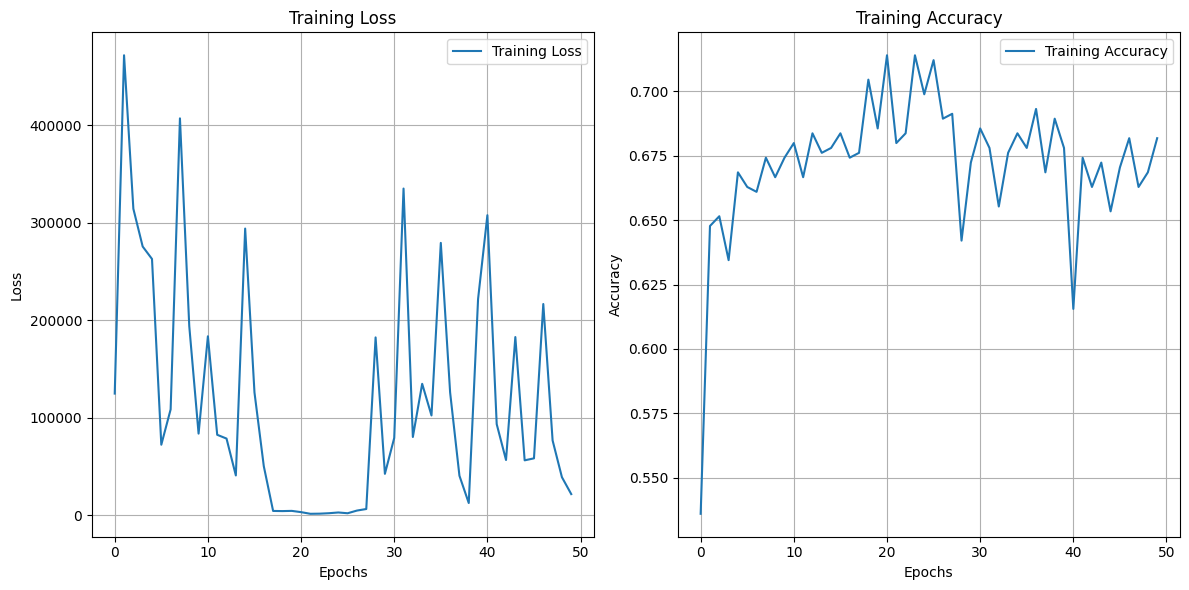

5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step 


         Class  Precision    Recall  F1-score  Accuracy
0          0.0   0.666667  0.041667  0.078431  0.666667
1          1.0   0.477273  0.976744  0.641221  0.477273
2          2.0   1.000000  1.000000  1.000000  1.000000
average    NaN   0.708506  0.643939  0.548009  0.643939


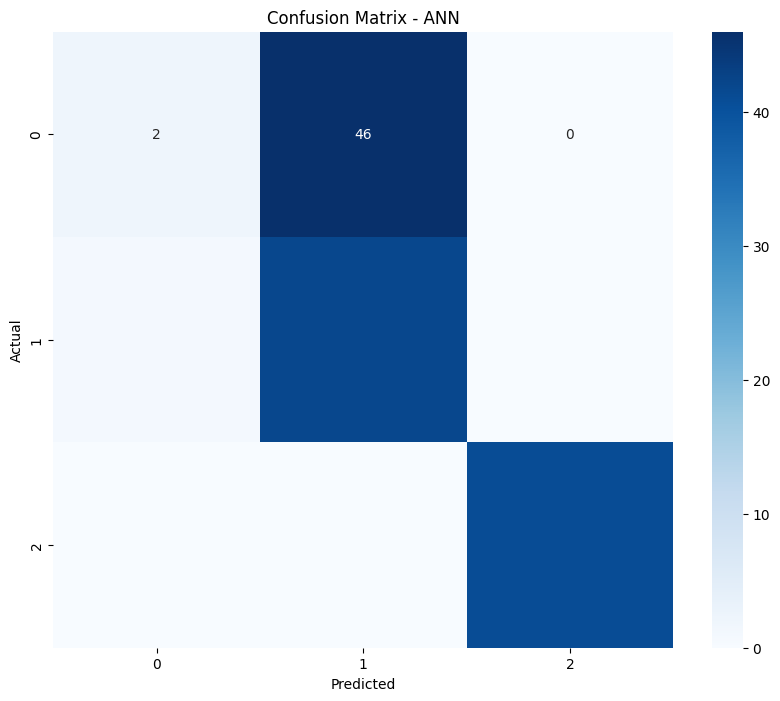

In [13]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.utils import to_categorical

# แปลง y_train และ y_test ให้เป็นแบบ one-hot encoding
num_classes = len(np.unique(y_train))
y_train_one_hot = to_categorical(y_train, num_classes=num_classes)
y_test_one_hot = to_categorical(y_test, num_classes=num_classes)

# สร้างโมเดล ANN แบบ Feed-Forward
ann_model = Sequential()
ann_model.add(Dense(128, input_dim=X_train.shape[1], activation='relu'))
ann_model.add(Dense(64, activation='relu'))
ann_model.add(Dense(num_classes, activation='softmax'))

# คอมไพล์โมเดล
ann_model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

# ฝึกโมเดล
ann_model.fit(X_train, y_train_one_hot, epochs=50, batch_size=32, verbose=1)

# Plot loss and accuracy
plt.figure(figsize=(12, 6))

# Plot training loss
plt.subplot(1, 2, 1)
plt.plot(ann_model.history.history['loss'], label='Training Loss')
plt.title('Training Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)

# Plot training accuracy
plt.subplot(1, 2, 2)
plt.plot(ann_model.history.history['accuracy'], label='Training Accuracy')
plt.title('Training Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()


# ทำนายบน test set
y_pred_ann = np.argmax(ann_model.predict(X_test), axis=1)

ann_model.save(f"model_FFT/ann_model_{name_data}.h5")



# ประเมิน precision, recall, และ F1-score ของแต่ละคลาส
precision_ann_per_class = precision_score(y_test, y_pred_ann, average=None)
recall_ann_per_class = recall_score(y_test, y_pred_ann, average=None)
f1_ann_per_class = f1_score(y_test, y_pred_ann, average=None)

# คำนวณ accuracy ของแต่ละคลาส
accuracy_ann_per_class = []
for class_label in range(len(precision_ann_per_class)):
    correct_predictions = ((y_pred_ann == class_label) & (y_test == class_label)).sum()
    total_predictions = (y_pred_ann == class_label).sum()
    accuracy = correct_predictions / total_predictions if total_predictions > 0 else 0
    accuracy_ann_per_class.append(accuracy)

# คำนวณค่าเฉลี่ยของ accuracy
avg_accuracy_ann = accuracy_score(y_test, y_pred_ann)

# เฉลี่ย precision, recall, และ F1-score ของแต่ละคลาส
avg_precision_ann = precision_score(y_test, y_pred_ann, average='weighted')
avg_recall_ann = recall_score(y_test, y_pred_ann, average='weighted')
avg_f1_ann = f1_score(y_test, y_pred_ann, average='weighted')

# สร้าง DataFrame จากผลลัพธ์
results_ann_df = pd.DataFrame({
    'Class': range(len(precision_ann_per_class)),
    'Precision': precision_ann_per_class,
    'Recall': recall_ann_per_class,
    'F1-score': f1_ann_per_class,
    'Accuracy': accuracy_ann_per_class
})

# เพิ่มค่าเฉลี่ยของ accuracy และ precision, recall, F1-score ลงในตาราง
results_ann_df.loc['average'] = [None, avg_precision_ann, avg_recall_ann, avg_f1_ann, avg_accuracy_ann]
print(results_ann_df)
conf_matrix_knn = confusion_matrix(y_test, y_pred_ann)
plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix_knn, annot=True, fmt="d", cmap="Blues", xticklabels=[0, 1, 2], yticklabels=[0, 1, 2])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix - ANN')
plt.show()



Epoch 1/100


C:\Users\Toey\AppData\Roaming\Python\Python311\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


17/17 ━━━━━━━━━━━━━━━━━━━━ 2s 20ms/step - accuracy: 0.6736 - loss: 1.0963
Epoch 2/100
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - accuracy: 0.9354 - loss: 0.2743
Epoch 3/100
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - accuracy: 0.9312 - loss: 0.3286
Epoch 4/100
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - accuracy: 0.9658 - loss: 0.1993
Epoch 5/100
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - accuracy: 0.9588 - loss: 0.1618
Epoch 6/100
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - accuracy: 0.9445 - loss: 0.1347
Epoch 7/100
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - accuracy: 0.9790 - loss: 0.1213
Epoch 8/100
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - accuracy: 0.9788 - loss: 0.0479
Epoch 9/100
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - accuracy: 0.9847 - loss: 0.1161
Epoch 10/100
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - accuracy: 0.9948 - loss: 0.0402
Epoch 11/100
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - accuracy: 0.9914 - loss: 0.0322
Epoch 12/100
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - accuracy:

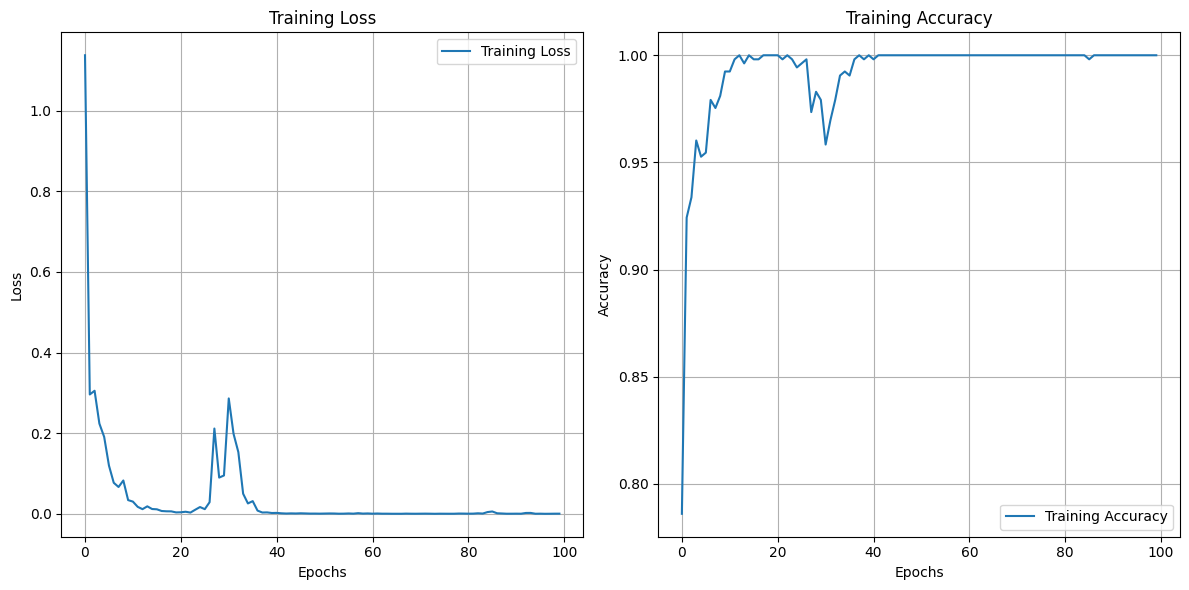

5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


         Class  Precision    Recall  F1-score  Accuracy
0          0.0   0.958333  0.958333  0.958333  0.958333
1          1.0   0.955556  1.000000  0.977273  0.955556
2          2.0   0.974359  0.926829  0.950000  0.974359
average    NaN   0.962406  0.962121  0.961915  0.962121


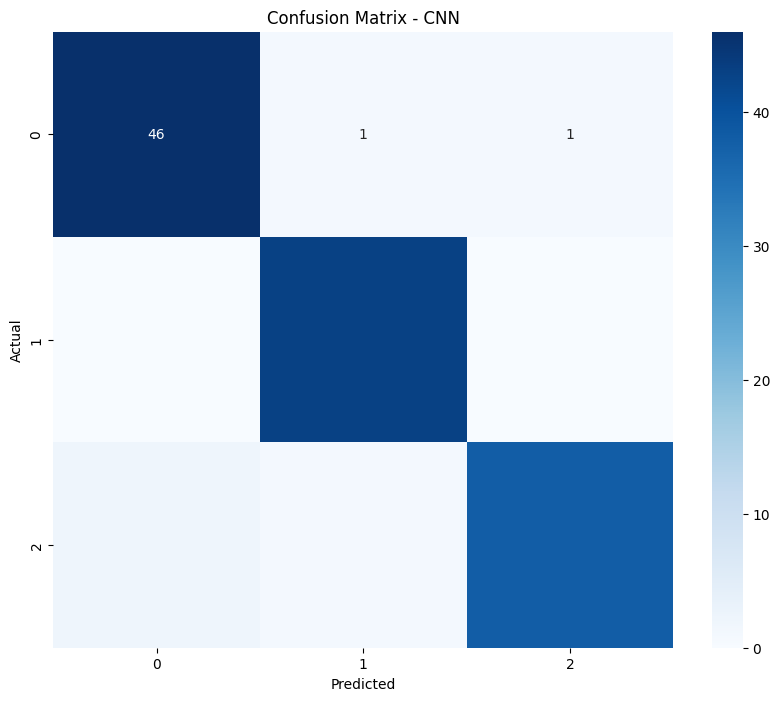

In [14]:
import numpy as np
import pandas as pd
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score, confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv1D, BatchNormalization, MaxPooling1D, Dense, ReLU, Softmax, Flatten
from tensorflow.keras.utils import to_categorical

# แบ่งข้อมูลเป็น train set และ test set
X_train, X_test, y_train, y_test = train_test_split(combined_data, labels, test_size=0.2, random_state=42)

# Normalize ข้อมูล
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)


# ปรับข้อมูลให้เป็นรูปแบบ 3D สำหรับ Conv1D
X_train_reshaped = X_train.reshape(-1, 363, 1)
X_test_reshaped = X_test.reshape(-1, 363, 1)

# สร้างโมเดล CNN สำหรับข้อมูล 1D
model = Sequential()

# Convolution Layer
model.add(Conv1D(filters=64, kernel_size=3, input_shape=(363, 1), padding='same'))
model.add(BatchNormalization())
model.add(MaxPooling1D(pool_size=2))
model.add(ReLU())

# เพิ่มอีก Convolution Layer
model.add(Conv1D(filters=64, kernel_size=3, padding='same'))
model.add(BatchNormalization())
model.add(MaxPooling1D(pool_size=2))
model.add(ReLU())

# Dense Layer
model.add(Flatten())
model.add(Dense(units=256))
model.add(ReLU())

# Output Layer
num_classes = len(np.unique(y_train))
model.add(Dense(units=num_classes))
model.add(Softmax())

# คอมไพล์โมเดล
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

# แปลง y_train และ y_test ให้เป็นแบบ one-hot encoding
y_train_one_hot = to_categorical(y_train, num_classes=num_classes)
y_test_one_hot = to_categorical(y_test, num_classes=num_classes)

# ฝึกโมเดล
model.fit(X_train_reshaped, y_train_one_hot, epochs=100, batch_size=32, verbose=1)

# Plot loss and accuracy
plt.figure(figsize=(12, 6))

# Plot training loss
plt.subplot(1, 2, 1)
plt.plot(model.history.history['loss'], label='Training Loss')
plt.title('Training Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)

# Plot training accuracy
plt.subplot(1, 2, 2)
plt.plot(model.history.history['accuracy'], label='Training Accuracy')
plt.title('Training Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()

# ทำนายบน test set
y_pred_cnn = np.argmax(model.predict(X_test_reshaped), axis=1)

dump(scaler, f'model_FFT/cnn_scaler_{name_data}.pkl')
model.save(f"model_FFT/cnn_model_{name_data}.h5")

# ประเมิน precision, recall, และ F1-score ของแต่ละคลาส
precision_cnn_per_class = precision_score(y_test, y_pred_cnn, average=None)
recall_cnn_per_class = recall_score(y_test, y_pred_cnn, average=None)
f1_cnn_per_class = f1_score(y_test, y_pred_cnn, average=None)

# คำนวณ accuracy ของแต่ละคลาส
accuracy_cnn_per_class = []
for class_label in range(len(precision_cnn_per_class)):
    correct_predictions = ((y_pred_cnn == class_label) & (y_test == class_label)).sum()
    total_predictions = (y_pred_cnn == class_label).sum()
    accuracy = correct_predictions / total_predictions if total_predictions > 0 else 0
    accuracy_cnn_per_class.append(accuracy)

# คำนวณค่าเฉลี่ยของ accuracy
avg_accuracy_cnn = accuracy_score(y_test, y_pred_cnn)

# เฉลี่ย precision, recall, และ F1-score ของแต่ละคลาส
avg_precision_cnn = precision_score(y_test, y_pred_cnn, average='weighted')
avg_recall_cnn = recall_score(y_test, y_pred_cnn, average='weighted')
avg_f1_cnn = f1_score(y_test, y_pred_cnn, average='weighted')

# สร้าง DataFrame จากผลลัพธ์
results_cnn_df = pd.DataFrame({
    'Class': range(len(precision_cnn_per_class)),
    'Precision': precision_cnn_per_class,
    'Recall': recall_cnn_per_class,
    'F1-score': f1_cnn_per_class,
    'Accuracy': accuracy_cnn_per_class
})


# เพิ่มค่าเฉลี่ยของ accuracy และ precision, recall, F1-score ลงในตาราง
results_cnn_df.loc['average'] = [None, avg_precision_cnn, avg_recall_cnn, avg_f1_cnn, avg_accuracy_cnn]
print(results_cnn_df)
conf_matrix_cnn = confusion_matrix(y_test, y_pred_cnn)
plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix_cnn, annot=True, fmt="d", cmap="Blues", xticklabels=[0, 1, 2], yticklabels=[0, 1, 2])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix - CNN')
plt.show()


Epoch 1/100


C:\Users\Toey\AppData\Roaming\Python\Python311\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


17/17 ━━━━━━━━━━━━━━━━━━━━ 10s 258ms/step - accuracy: 0.3331 - loss: 1.1333 - val_accuracy: 0.3333 - val_loss: 1.1233 - learning_rate: 0.0010
Epoch 2/100
17/17 ━━━━━━━━━━━━━━━━━━━━ 3s 199ms/step - accuracy: 0.3808 - loss: 1.1207 - val_accuracy: 0.3182 - val_loss: 1.1198 - learning_rate: 0.0010
Epoch 3/100
17/17 ━━━━━━━━━━━━━━━━━━━━ 3s 204ms/step - accuracy: 0.3687 - loss: 1.1132 - val_accuracy: 0.3182 - val_loss: 1.1260 - learning_rate: 0.0010
Epoch 4/100
17/17 ━━━━━━━━━━━━━━━━━━━━ 3s 197ms/step - accuracy: 0.3415 - loss: 1.1060 - val_accuracy: 0.3409 - val_loss: 1.1560 - learning_rate: 0.0010
Epoch 5/100
17/17 ━━━━━━━━━━━━━━━━━━━━ 4s 210ms/step - accuracy: 0.3459 - loss: 1.1053 - val_accuracy: 0.3333 - val_loss: 1.1510 - learning_rate: 0.0010
Epoch 6/100
17/17 ━━━━━━━━━━━━━━━━━━━━ 4s 207ms/step - accuracy: 0.3609 - loss: 1.0910 - val_accuracy: 0.3333 - val_loss: 1.1539 - learning_rate: 0.0010
Epoch 7/100
17/17 ━━━━━━━━━━━━━━━━━━━━ 4s 209ms/step - accuracy: 0.3423 - loss: 1.0895 - val_

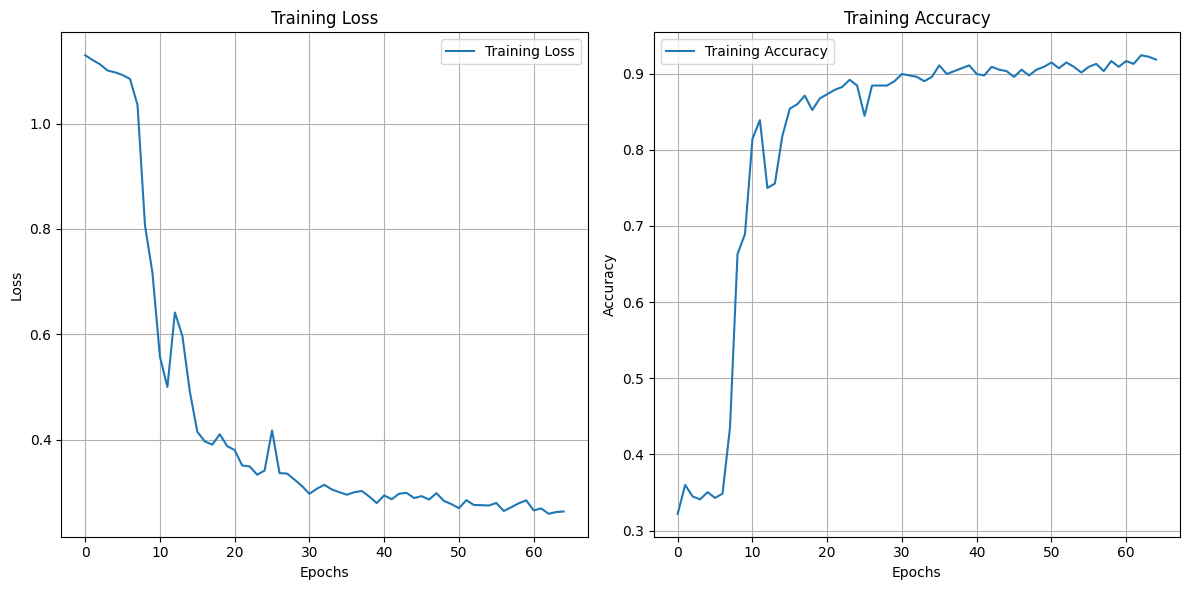

4/5 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/stepWARNING:tensorflow:5 out of the last 11 calls to <function TensorFlowTrainer.make_predict_function.<locals>.one_step_on_data_distributed at 0x0000022B6E947060> triggered tf.function retracing. Tracing is expensive and the excessive number of tracings could be due to (1) creating @tf.function repeatedly in a loop, (2) passing tensors with different shapes, (3) passing Python objects instead of tensors. For (1), please define your @tf.function outside of the loop. For (2), @tf.function has reduce_retracing=True option that can avoid unnecessary retracing. For (3), please refer to https://www.tensorflow.org/guide/function#controlling_retracing and https://www.tensorflow.org/api_docs/python/tf/function for  more details.


5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 162ms/step
         Class  Precision    Recall  F1-score  Accuracy
0          0.0   0.829268  0.772727  0.800000  0.829268
1          1.0   0.914894  0.977273  0.945055  0.914894
2          2.0   0.818182  0.818182  0.818182  0.818182
average    NaN   0.854115  0.856061  0.854412  0.856061


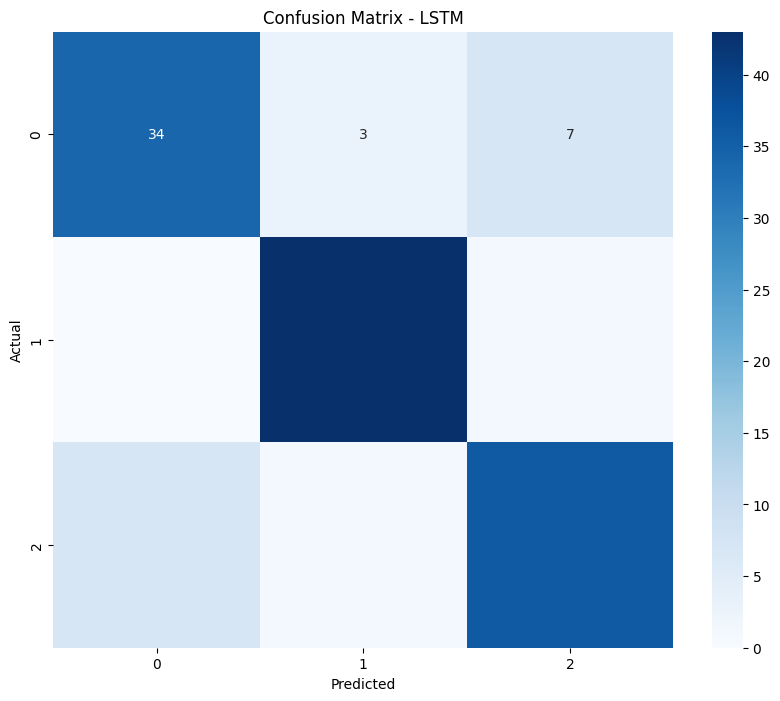

In [15]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score, confusion_matrix
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout, Bidirectional
from tensorflow.keras.regularizers import l2
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping

# แบ่งข้อมูลเป็น train set และ test set
X_train, X_test, y_train, y_test = train_test_split(combined_data, labels, test_size=0.2, random_state=42, stratify=labels)

# Normalize ข้อมูล
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# ปรับข้อมูลให้เป็นรูปแบบ 3D สำหรับ LSTM
X_train_reshaped = X_train.reshape(-1, 363, 1)
X_test_reshaped = X_test.reshape(-1, 363, 1)

# สร้างโมเดล LSTM
model = Sequential()

# LSTM Layer 1
model.add(Bidirectional(LSTM(50, return_sequences=True, input_shape=(363, 1), kernel_regularizer=l2(0.0001))))
model.add(Dropout(0.3))

# LSTM Layer 2
model.add(Bidirectional(LSTM(70, return_sequences=False, kernel_regularizer=l2(0.0001))))
model.add(Dropout(0.3))

# Fully Connected Layer
model.add(Dense(5, activation='relu'))

# Output Layer with Softmax
model.add(Dense(len(np.unique(y_train)), activation='softmax'))

# คอมไพล์โมเดล
optimizer = tf.keras.optimizers.Adam(learning_rate=0.001)
model.compile(loss='categorical_crossentropy', optimizer=optimizer, metrics=['accuracy'])

# แปลง y_train และ y_test ให้เป็นแบบ one-hot encoding
y_train_one_hot = tf.keras.utils.to_categorical(y_train, num_classes=len(np.unique(y_train)))
y_test_one_hot = tf.keras.utils.to_categorical(y_test, num_classes=len(np.unique(y_train)))

# Reduce learning rate when a metric has stopped improving.
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=10, min_lr=0.00001, verbose=1)

# Early stopping to avoid overfitting
early_stopping = EarlyStopping(monitor='val_loss', patience=15, restore_best_weights=True, verbose=1)

# ฝึกโมเดล
model.fit(X_train_reshaped, y_train_one_hot, epochs=100, batch_size=32, validation_data=(X_test_reshaped, y_test_one_hot), callbacks=[reduce_lr, early_stopping], verbose=1)
# Plot loss and accuracy
plt.figure(figsize=(12, 6))

# Plot training loss
plt.subplot(1, 2, 1)
plt.plot(model.history.history['loss'], label='Training Loss')
plt.title('Training Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)

# Plot training accuracy
plt.subplot(1, 2, 2)
plt.plot(model.history.history['accuracy'], label='Training Accuracy')
plt.title('Training Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()
model.save(f"model_FFT/lstm_model_{name_data}.h5")
dump(scaler, f'model_FFT/lstm_scaler_{name_data}.pkl')

# ทำนายบน test set
y_pred_lstm = np.argmax(model.predict(X_test_reshaped), axis=1)

# ประเมิน precision, recall, และ F1-score ของแต่ละคลาส
precision_lstm_per_class = precision_score(y_test, y_pred_lstm, average=None)
recall_lstm_per_class = recall_score(y_test, y_pred_lstm, average=None)
f1_lstm_per_class = f1_score(y_test, y_pred_lstm, average=None)

# คำนวณ accuracy ของแต่ละคลาส
accuracy_lstm_per_class = []
for class_label in range(len(precision_lstm_per_class)):
    correct_predictions = ((y_pred_lstm == class_label) & (y_test == class_label)).sum()
    total_predictions = (y_pred_lstm == class_label).sum()
    accuracy = correct_predictions / total_predictions if total_predictions > 0 else 0
    accuracy_lstm_per_class.append(accuracy)

# คำนวณค่าเฉลี่ยของ accuracy
avg_accuracy_lstm = accuracy_score(y_test, y_pred_lstm)

# เฉลี่ย precision, recall, และ F1-score ของแต่ละคลาส
avg_precision_lstm = precision_score(y_test, y_pred_lstm, average='weighted')
avg_recall_lstm = recall_score(y_test, y_pred_lstm, average='weighted')
avg_f1_lstm = f1_score(y_test, y_pred_lstm, average='weighted')

# สร้าง DataFrame จากผลลัพธ์
results_lstm_df = pd.DataFrame({
    'Class': range(len(precision_lstm_per_class)),
    'Precision': precision_lstm_per_class,
    'Recall': recall_lstm_per_class,
    'F1-score': f1_lstm_per_class,
    'Accuracy': accuracy_lstm_per_class
})

# เพิ่มค่าเฉลี่ยของ accuracy และ precision, recall, F1-score ลงในตาราง
results_lstm_df.loc['average'] = [None, avg_precision_lstm, avg_recall_lstm, avg_f1_lstm, avg_accuracy_lstm]

print(results_lstm_df)


conf_matrix_lstm = confusion_matrix(y_test, y_pred_lstm)
plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix_lstm, annot=True, fmt="d", cmap="Blues", xticklabels=[0, 1, 2], yticklabels=[0, 1, 2])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix - LSTM')
plt.show()


Epoch 1/50


C:\Users\Toey\AppData\Roaming\Python\Python311\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - accuracy: 0.5358 - loss: 0.9849 - val_accuracy: 0.8302 - val_loss: 0.6544
Epoch 2/50
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.7927 - loss: 0.6277 - val_accuracy: 0.9245 - val_loss: 0.4160
Epoch 3/50
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.8453 - loss: 0.4856 - val_accuracy: 0.9340 - val_loss: 0.3059
Epoch 4/50
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9219 - loss: 0.3188 - val_accuracy: 0.9528 - val_loss: 0.2238
Epoch 5/50
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.8967 - loss: 0.2786 - val_accuracy: 0.9528 - val_loss: 0.2020
Epoch 6/50
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9304 - loss: 0.2294 - val_accuracy: 0.9434 - val_loss: 0.1984
Epoch 7/50
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.9329 - loss: 0.2026 - val_accuracy: 0.9528 - val_loss: 0.1526
Epoch 8/50
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9371 - loss: 0.1869 - val_accuracy: 0.9434 - val_loss: 0.1565
Ep

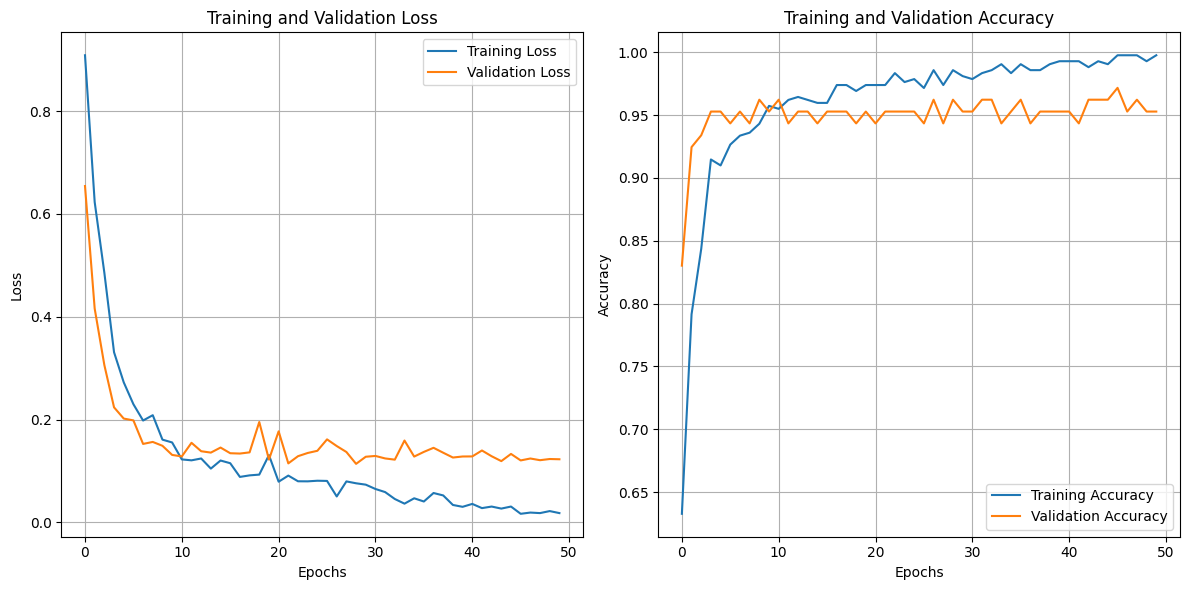

AttributeError: 'Sequential' object has no attribute 'predict_classes'

In [18]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.utils import to_categorical

# ปรับโครงสร้างของโมเดล ANN
ann_model = Sequential([
    Dense(128, input_dim=X_train.shape[1], activation='relu'),
    Dropout(0.2),  # เพิ่ม Dropout เพื่อลดการ Overfitting
    Dense(64, activation='relu'),
    Dropout(0.2),
    Dense(num_classes, activation='softmax')
])

# คอมไพล์โมเดล
ann_model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

# ฝึกโมเดล
history = ann_model.fit(X_train, y_train_one_hot, epochs=50, batch_size=32, verbose=1, validation_split=0.2)

# ประเมินโมเดลบนชุดทดสอบ
loss, accuracy = ann_model.evaluate(X_test, y_test_one_hot)
print("Test Accuracy:", accuracy)

# สร้างกราฟแสดงค่า Loss และ Accuracy ในระหว่างการฝึก
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 6))

# Plot training loss
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)

# Plot training accuracy
plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()
y_pred_ann = ann_model.predict_classes(X_test)

# ประเมิน precision, recall, และ F1-score ของแต่ละคลาส
precision_ann_per_class = precision_score(y_test, y_pred_ann, average=None)
recall_ann_per_class = recall_score(y_test, y_pred_ann, average=None)
f1_ann_per_class = f1_score(y_test, y_pred_ann, average=None)

# คำนวณ accuracy ของแต่ละคลาส
accuracy_ann_per_class = []
for class_label in range(len(precision_ann_per_class)):
    correct_predictions = ((y_pred_ann == class_label) & (y_test == class_label)).sum()
    total_predictions = (y_pred_ann == class_label).sum()
    accuracy = correct_predictions / total_predictions if total_predictions > 0 else 0
    accuracy_ann_per_class.append(accuracy)

# คำนวณค่าเฉลี่ยของ accuracy
avg_accuracy_ann = accuracy_score(y_test, y_pred_ann)

# เฉลี่ย precision, recall, และ F1-score ของแต่ละคลาส
avg_precision_ann = precision_score(y_test, y_pred_ann, average='weighted')
avg_recall_ann = recall_score(y_test, y_pred_ann, average='weighted')
avg_f1_ann = f1_score(y_test, y_pred_ann, average='weighted')

# สร้าง DataFrame จากผลลัพธ์
results_ann_df = pd.DataFrame({
    'Class': range(len(precision_ann_per_class)),
    'Precision': precision_ann_per_class,
    'Recall': recall_ann_per_class,
    'F1-score': f1_ann_per_class,
    'Accuracy': accuracy_ann_per_class
})

# เพิ่มค่าเฉลี่ยของ accuracy และ precision, recall, F1-score ลงในตาราง
results_ann_df.loc['average'] = [None, avg_precision_ann, avg_recall_ann, avg_f1_ann, avg_accuracy_ann]
print(results_ann_df)

# แสดง Confusion Matrix
conf_matrix_ann = confusion_matrix(y_test, y_pred_ann)
plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix_ann, annot=True, fmt="d", cmap="Blues", xticklabels=[0, 1, 2], yticklabels=[0, 1, 2])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix - ANN')
plt.show()
